##  <font color="green"> Importation de data </font> 

In [53]:

################################
import sys
import pandas as pd
from numpy import array
import matplotlib.pyplot as plt

df = pd.read_csv("data/hdf_desaisonalisé.csv", names=['value'], header=0)
# print(df)
print(df.head())

                           value
2012-12-31 00:00:00+00:00    NaN
2013-01-01 00:00:00+00:00    NaN
2013-01-02 00:00:00+00:00    NaN
2013-01-03 00:00:00+00:00    NaN
2013-01-04 00:00:00+00:00    NaN


##  <font color="green"> Traitement de l'information </font> 

In [54]:
#######################################
# checking for null values
print("null",df.isnull().sum())

df=df.dropna()
print(df.isnull().sum())

null value    364
dtype: int64
value    0
dtype: int64


##  <font color="green"> Vérifier la saisonnalité </font> 

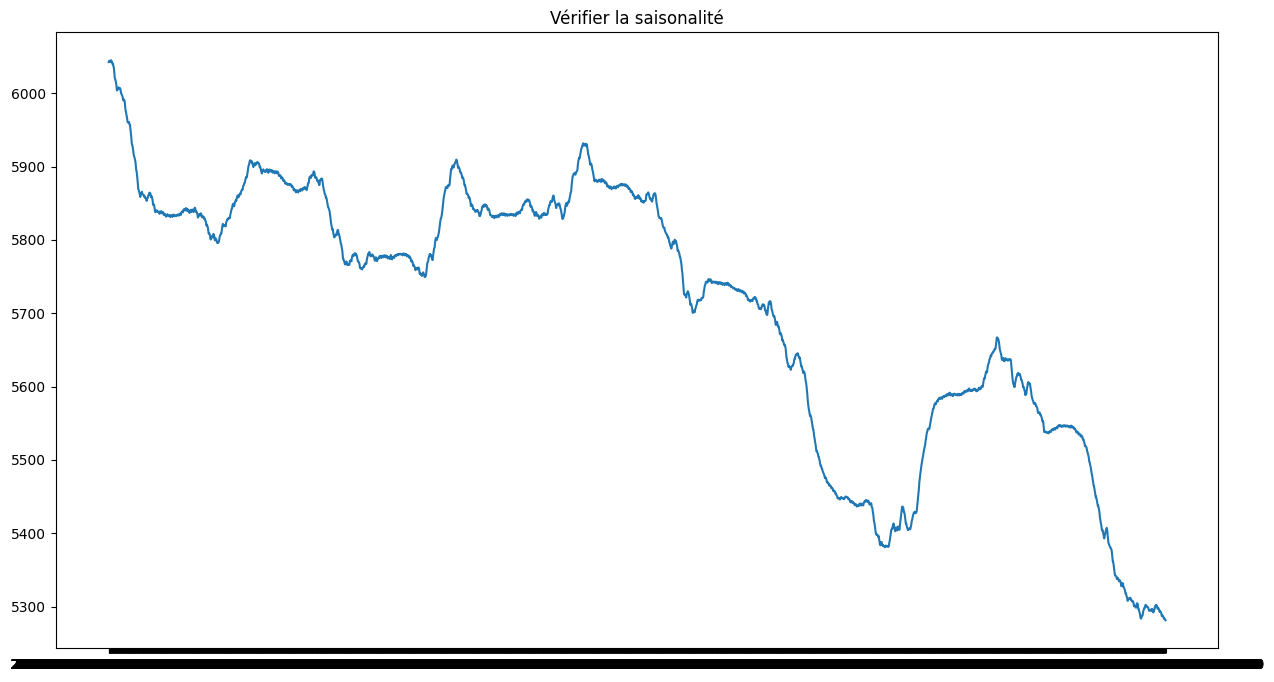

In [55]:
#####################################
# Plot Series
plt.figure(figsize=(15,8))
plt.plot(df.value)
plt.title("Vérifier la saisonalité")
plt.show()


### Le résultat montre qu'il y a une saisonnalité dans la série, le processus de différenciation doit être associé pour le supprimer.

##  <font color="green"> Éliminer la saisonnalité </font> 

###  <font color="green"> Moving Average ---Déterminer q à partir de ACF </font> 

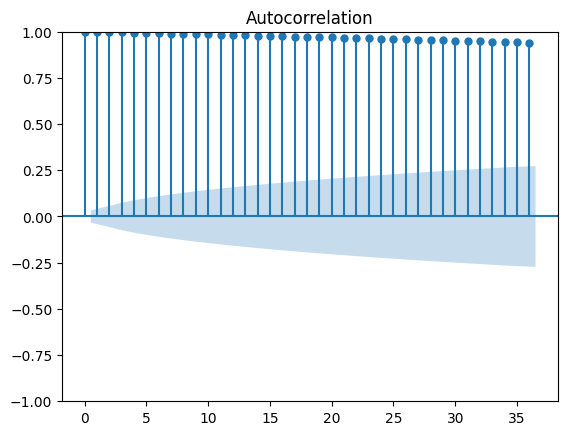

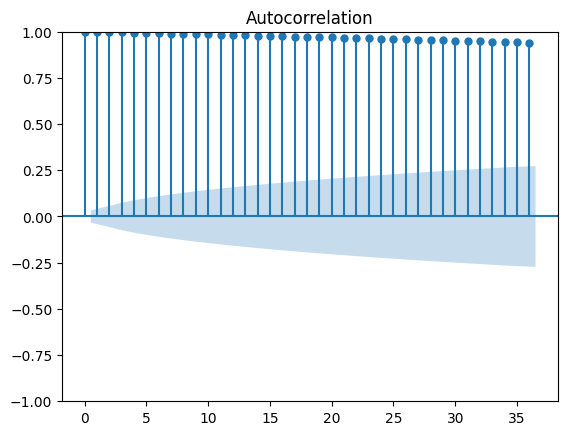

In [56]:
#importing modules
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df.value)

###  <font color="green"> La première différenciation et la deuxième différenciation pour améliorer la nature stationnaire</font> 

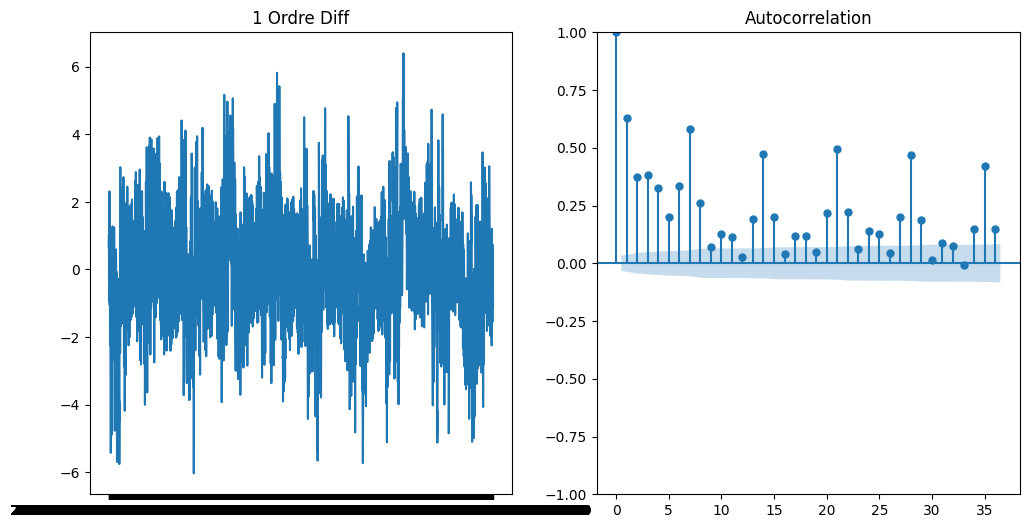

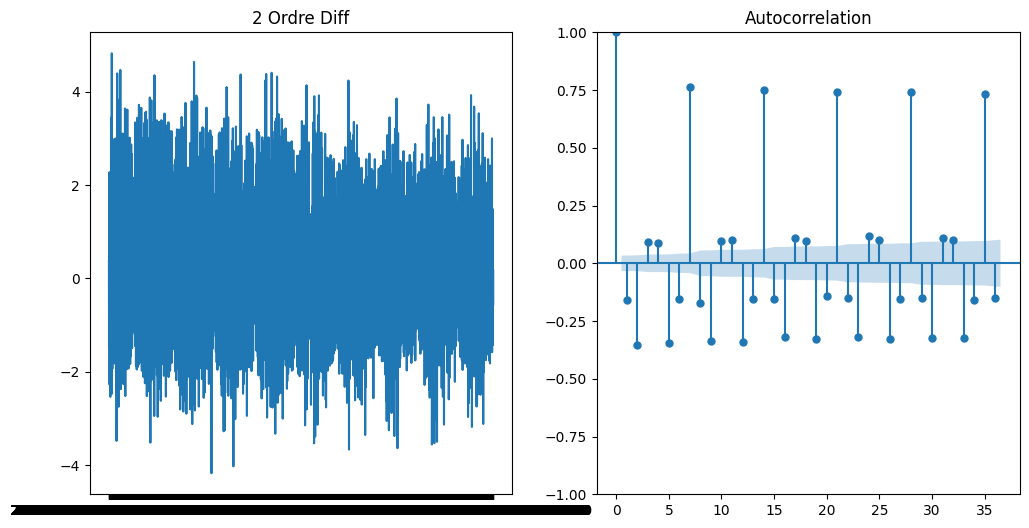

In [64]:
#1rst order differencing
f = plt.figure(figsize=(12, 6))
ax1=f.add_subplot(121)
ax1.set_title('1 Ordre Diff')
ax1.plot(df.value.diff())


ax2=f.add_subplot(122)
plot_acf(df.value.diff().dropna() , ax= ax2)
#plt.show()

#2nd order differencing
f = plt.figure(figsize=(12, 6))
ax1=f.add_subplot(121)
ax1.set_title('2 Ordre Diff')
ax1.plot(df.value.diff().diff())

ax2=f.add_subplot(122)
plot_acf(df.value.diff().diff().dropna() , ax= ax2)
plt.show()

A partir du 1er differenciation, on vois la série sans tendance. On vas vérifier sa stationarité après. Alors, d=1.

La figure de l'acf de 1 ordre diff nous aide à connaitre le q: q=4 dans ce cas là.

###  <font color="green"> Vérifier la stationarité </font> 

In [65]:
# ADF Test
from statsmodels.tsa.stattools import adfuller
# perform augmented Dickey-Fuller test
#  H0: The time series is non-stationary.
#  HA: The time series is stationary.
# Suppose Test statistic: -3.0952105155554577
# Suppose P-value: 0.026909668130736933
# Since the p-value is not less than 0.05, we fail to reject the null hypothesis.

##################################################################
result_diff_1  = adfuller(df.value.diff().dropna())
p_value_1 = result_diff_1[1]
print ('p_value_Diff_order_1 = ' , p_value_1) # 1.17909511e-17

# Comparer la p-value à un seuil de significativité (par exemple, 0.05)
if p_value_1 <= 0.05:
    print("La série temporelle désaisonnalisé est stationnaire autour d'un trend (rejet de H0)")
else:
    print("La série temporelle désaisonnalisé n'est pas stationnaire autour d'un trend (absence de rejet de H0)")
###################################################################
result_diff_2  = adfuller(df.value.diff().diff().dropna())
p_value_2 = result_diff_2[1]

print ('p_value_Diff_order_2 = ' , p_value_2) # 1.114936294e-11   

# Comparer la p-value à un seuil de significativité (par exemple, 0.05)
if p_value_2 <= 0.05:
    print("La série temporelle désaisonnalisé est stationnaire autour d'un trend (rejet de H0)")
else:
    print("La série temporelle désaisonnalisé n'est pas stationnaire autour d'un trend (absence de rejet de H0)")

p_value_Diff_order_1 =  1.09316000133935e-09
La série temporelle désaisonnalisé est stationnaire autour d'un trend (rejet de H0)
p_value_Diff_order_2 =  2.9511413105063134e-28
La série temporelle désaisonnalisé est stationnaire autour d'un trend (rejet de H0)


### Alors on prend d=1. Il suffit un seul differentiation pour rendre la série stationnaire.

###  <font color="green"> Déterminer p à partir de PACF </font> 

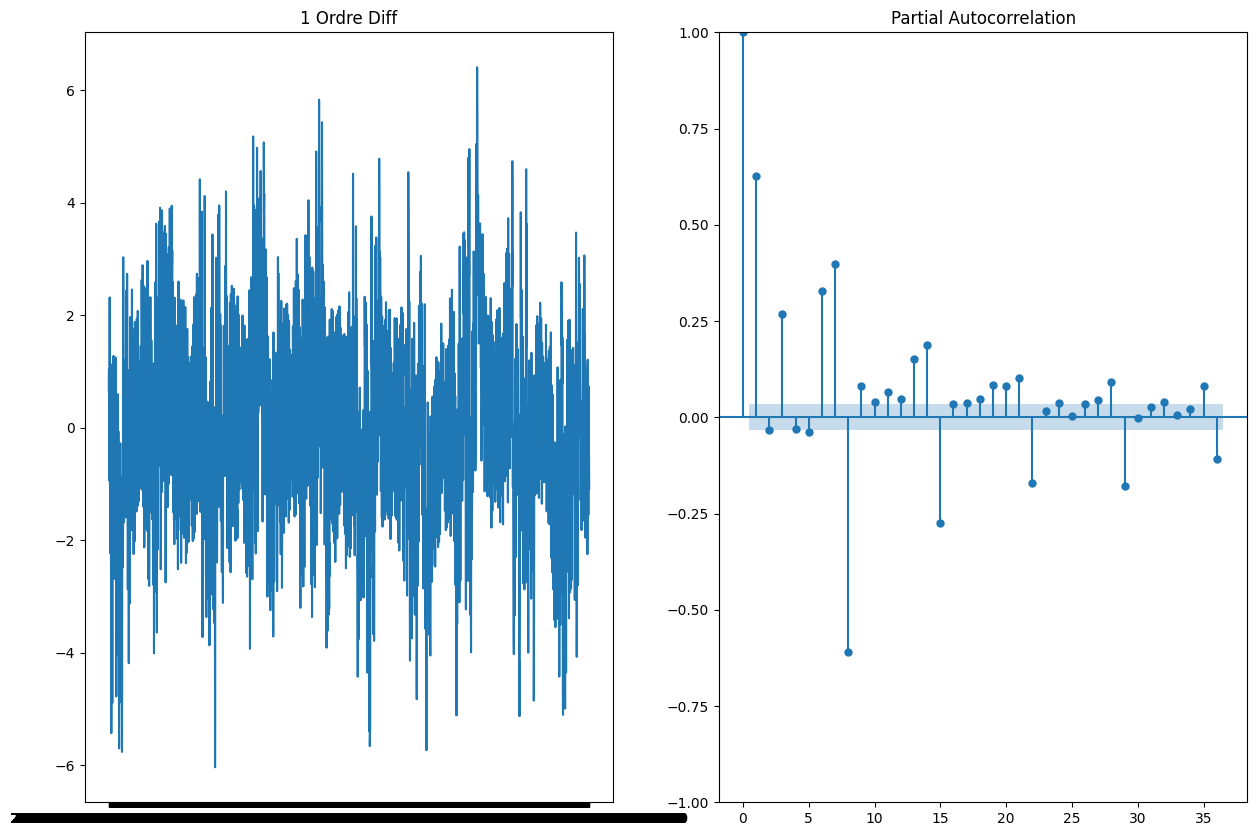

In [66]:
# # ####################### Auto Regression p: PACF #############
from statsmodels.graphics.tsaplots import plot_pacf

f = plt.figure(figsize=(15, 10))
ax1=f.add_subplot(121)
ax1.set_title('1 Ordre Diff')
ax1.plot(df.value.diff())
ax2=f.add_subplot(122)
plot_pacf(df.value.diff().dropna() , ax= ax2)
plt.show()

La figure de PACF peut nous aider à calculer p. Dans ce cas là, p=1.

/home/apprenant/miniconda3/envs/myenv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/apprenant/miniconda3/envs/myenv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/apprenant/miniconda3/envs/myenv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                 3470
Model:                 ARIMA(1, 1, 4)   Log Likelihood               -5575.072
Date:                Tue, 19 Sep 2023   AIC                          11162.143
Time:                        13:31:43   BIC                          11199.053
Sample:                    07-01-2013   HQIC                         11175.322
                         - 12-30-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1301      0.087     -1.489      0.137      -0.301       0.041
ma.L1          0.8268      0.082     10.022      0.000       0.665       0.988
ma.L2          0.5152      0.052      9.967      0.0

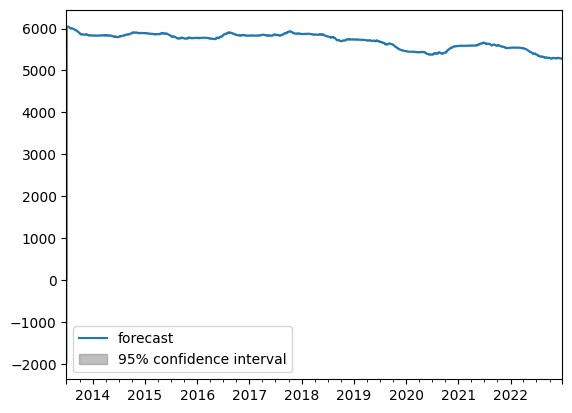

In [100]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict

# Ajuster le modèle ARIMA
p, d, q = 1, 1, 4  # Les valeurs déterminées à partir des graphiques ACF et PACF
model = ARIMA(df.value, order=(p, d, q ))
model_fit = model.fit()

# Résumé du modèle
print(model_fit.summary())

c=plot_predict(model_fit,dynamic=False)
plt.show()


# # Plot residual errors
# residuals = pd.DataFrame(model_fit.resid)
# fig, ax = plt.subplots(1,2, figsize=(25, 6))
# residuals.plot(title="Residuals", ax=ax[0])
# residuals.plot(kind='kde', title='Density', ax=ax[1])
# plt.show()

# # Prévisions
# n_forecast = 10  # Nombre de périodes de prévision
# forecast, stderr, conf_int = results.forecast(steps=n_forecast)

# # # Tracer les prévisions
# # plt.figure(figsize=(12, 6))
# # plt.plot(df, label='Données observées')
# # plt.plot(pd.date_range(start=df.index[-1], periods=n_forecast + 1, closed='right'), [df.iloc[-1]] + list(forecast), label='Prévisions', color='red')
# # plt.fill_between(pd.date_range(start=df.index[-1], periods=n_forecast + 1, closed='right'), [df.iloc[-1]] + list(conf_int[:, 0]), [df.iloc[-1]] + list(conf_int[:, 1]), color='pink', alpha=0.5, label='Intervalle de confiance')
# # plt.title('Prévisions avec le modèle ARIMA')
# # plt.xlabel('Date')
# # plt.ylabel('Valeur')
# # plt.legend()
# # plt.show()






La colonne P>|z| affiche les valeurs p associées à chaque paramètre du modèle. Une valeur p est une mesure de la significativité statistique d'un paramètre. Plus la valeur p est faible (généralement inférieure à 0,05), plus le paramètre est considéré comme significatif.

Alors ici on voit que la première variable n'est pas statistiquement significatif et peut être omis du modèle pour simplifier celui-ci. Cette vaiable represente la premier coefficient de AR.

## Améliorer le modèle ARIMA en modifiant les paramètres non significatifs et en utilisant l'AIC comme guide

/home/apprenant/miniconda3/envs/myenv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/apprenant/miniconda3/envs/myenv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/apprenant/miniconda3/envs/myenv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                 3470
Model:                 ARIMA(1, 1, 3)   Log Likelihood               -5633.806
Date:                Tue, 19 Sep 2023   AIC                          11277.611
Time:                        13:05:33   BIC                          11308.369
Sample:                    07-01-2013   HQIC                         11288.593
                         - 12-30-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9252      0.011     80.994      0.000       0.903       0.948
ma.L1         -0.2631      0.022    -11.880      0.000      -0.306      -0.220
ma.L2         -0.4753      0.017    -27.974      0.0

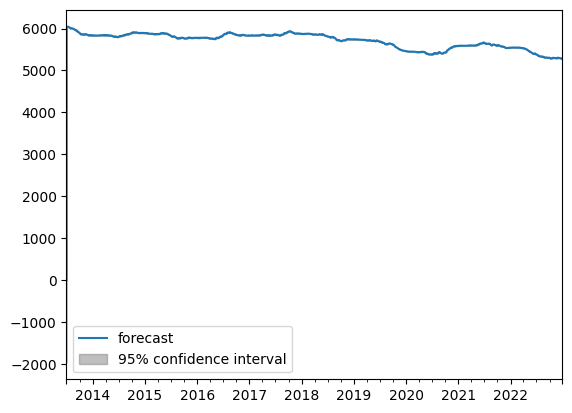

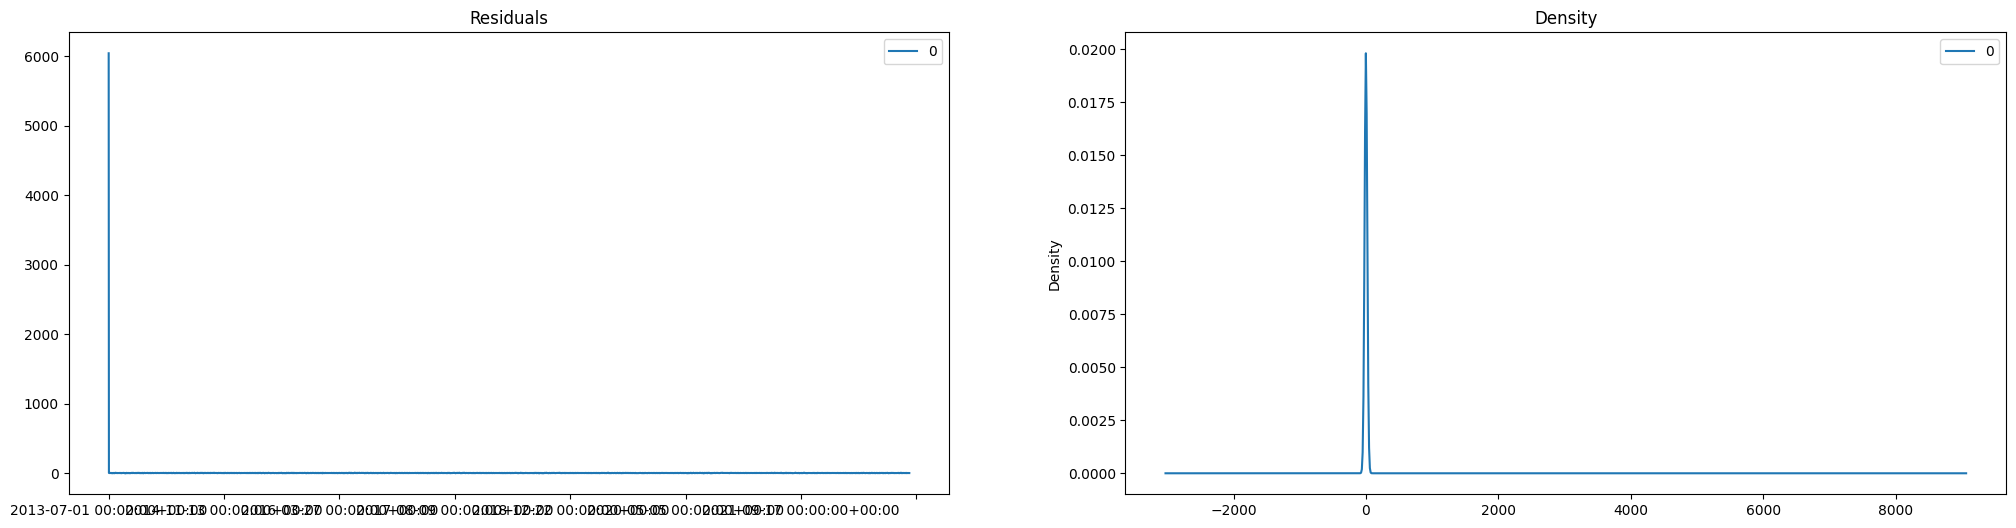

In [92]:
# Ajuster le modèle ARIMA
# réduire q à une valeur plus faible
p, d, q = 1, 1, 3  # Les valeurs déterminées à partir des graphiques ACF et PACF
model = ARIMA(df.value, order=(p, d, q ))
model_fit = model.fit()
# Get the fitted values
fitted_values = model_fit.fittedvalues

# Résumé du modèle
print(model_fit.summary())

c=plot_predict(model_fit,dynamic=False)
plt.show()

# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2, figsize=(25, 6))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

## Test pour meilleurs paramètres pour ARIMA

In [98]:
best_aic = float("inf")  # Initialize with a high value
best_p, best_d, best_q = None, None, None

train = df.value[:164]
y = df.value[:164]

for p in range(4):
    for d in range(4):
        for q in range(4):
            model = ARIMA(train, order=(p, d, q))
            model_fit = model.fit()
            
            # Calculate AIC
            aic = model_fit.aic
            
            if aic < best_aic:
                best_aic = aic
                best_p, best_d, best_q = p, d, q

# Now 'best_p', 'best_d', and 'best_q' contain the best parameter combination
print("Best p, d, q:", best_p, best_d, best_q)
print("Best AIC:", best_aic)


/home/apprenant/miniconda3/envs/myenv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/apprenant/miniconda3/envs/myenv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/apprenant/miniconda3/envs/myenv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/apprenant/miniconda3/envs/myenv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/apprenant/miniconda3/envs/myenv/lib/python3.10/site-packages/statsmodels/tsa/b

Best p, d, q: 3 2 3
Best AIC: 516.7434298035269


/home/apprenant/miniconda3/envs/myenv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


## ARIMA modèle avec ses meilleurs paramètres

/home/apprenant/miniconda3/envs/myenv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/apprenant/miniconda3/envs/myenv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/apprenant/miniconda3/envs/myenv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/apprenant/miniconda3/envs/myenv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/apprenant/miniconda3/envs/myenv/

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                 3470
Model:                 ARIMA(3, 2, 3)   Log Likelihood               -5075.516
Date:                Tue, 19 Sep 2023   AIC                          10165.033
Time:                        13:32:50   BIC                          10208.092
Sample:                    07-01-2013   HQIC                         10180.407
                         - 12-30-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4121      0.013     31.358      0.000       0.386       0.438
ar.L2         -0.6081      0.007    -85.241      0.000      -0.622      -0.594
ar.L3          0.8391      0.013     66.356      0.0

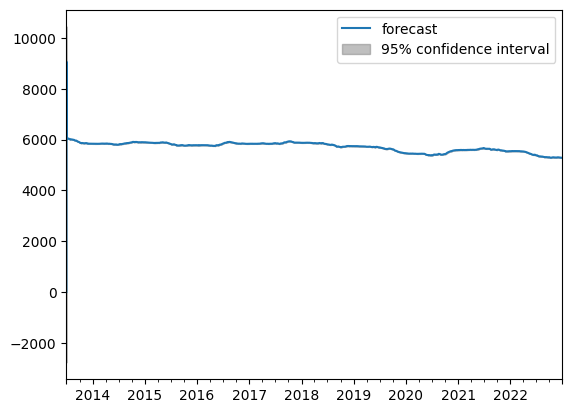

In [101]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict

# Ajuster le modèle ARIMA
p, d, q = 3, 2, 3  
model = ARIMA(df.value, order=(p, d, q ))
model_fit = model.fit()

# Résumé du modèle
print(model_fit.summary())

c=plot_predict(model_fit,dynamic=False)
plt.show()